#ANN with sigma profiles - reproduction


In this colab we tried to reproduce the ANN presented in [this paper](https://doi.org/10.1039/D2GC04425K), and we discuss the small differences that we found while doing so.

In [1]:
from __future__ import absolute_import
import pandas as pd
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['figure.figsize'] = [7, 5]
import seaborn as sb

from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.nn.functional import normalize

import sklearn
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [2]:
import random
# random seed for Python's random module
seed = 42
random.seed(seed)

# random seed for NumPy
np.random.seed(seed)

# random seed for PyTorch
torch.manual_seed(seed)

# If you are using CUDA (GPU), you should also set the seed for CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Additional steps to configure CUDA for deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Comparison of dataset statistics

This table shows a comparison between the statistics shown in the paper (in Section 2.2) regarding the dataset, and the available (uncleaned) dataset

| Statistic             | Original paper    | Dataset           | Match?|
|-----------------------|-------------------|-------------------|-------|
| Number of data points | 1973              | 1973              | ✅
| Number of DES         | 132               | 130               | ❌
| Range of molar ratios | 1:1 - 1:16        | 1:1 - 1:16        | ✅
| Range of temperatures | 293.15 - 348.15 K | 293.15 - 348.15 K | ✅
| Range of pressures    | 26.3 - 7620 kPa   | 26.3 - 7620 kPa   | ✅
| Number of HBAs        | 23                | 31                | ❌
| Number of HBDs        | 25                | 33                | ❌


There are some mismatches 🤔. Let's see if we can detect where is this coming from...


Number of datapoints

In [3]:
df = pd.read_csv('data.csv')
df.shape[0]

1973

Number of DES

In [4]:
df['DES'].nunique()

130

In [5]:
df['DES name'] =  df['DES'].str.replace(r"\s*\([^)]*\)", "", regex=True)
df['DES name'].nunique()

79

Range of molar ratios

In [6]:
df[['r HBA', 'r HBD']] = df['DES'].str.extract(r"\((\d+(?:\.\d+)?)\s*:\s*(\d+(?:\.\d+)?)\)").astype(float)

In [7]:
df['r HBA'].min()

1.0

In [8]:
df['r HBD'].max()

16.0

In [9]:
print(np.isnan(df['r HBA'].to_numpy()).any())
print(np.isnan(df['r HBD'].to_numpy()).any())

False
False


Range of temperatures

In [10]:
df['T (K)'].min()

293.15

In [11]:
df['T (K)'].max()

348.15

Range of pressures

In [12]:
df['P (kPa)'].min()

26.3

In [13]:
df['P (kPa)'].max()

7620.0

Number of HBAs

In [14]:
df['HBA name'] = df['DES'].str.extract(r'^([^-]+)')
df['HBA name'].nunique()

31

Number of HBDs

In [15]:
df['HBD name'] = df['DES'].str.extract(r'-([^-]+.*?)(?=\s*\()')
df['HBD name'] = df['HBD name'].str.strip()
df['HBD name'].nunique()

35

#### Explaining differences

As can be seen the original raw dataset has some discrepancies with the statistics reported by the paper. The reason for apparently having more HBAs and HBDs than reported, it is the lack of consistent naming. Let's fix this

In [16]:
df['HBA name'].unique()

array(['[Ach]Cl', 'Thymol', '[Ch]Cl', '[TOA]Cl', '[TOA]Br', 'BTEACl',
       'BTMACl', 'ChCl', 'TBABr', 'TBACl', 'TEACl', 'TMACl', 'TEMACl',
       '[Gua]Cl', '[TBA]Cl', '[TOMA]Cl', '[TOMA]Br', '[TBA]Br',
       '[BHDE]Cl', '[TEA]Br', 'L', 'MTPPBr', '[MTPP]Br',
       'DiethylammoniumCl', '[TEA]Cl', '[TMA]Cl', 'Betain', 'TPACl',
       '[TBP]Br', '[ATPP]Br', '[TPA]Cl'], dtype=object)

In [17]:
correction_HBA_names = {
    '[Ach]Cl':'[ACh]Cl',
    'BTEACl':'[BTEA]Cl',
    'BTMACl':'[BTMA]Cl',
    'ChCl':'[Ch]Cl',
    'TBABr':'[TBA]Br',
    'TBACl':'[TBA]Cl',
    'TEACl':'[TEA]Cl',
    'TMACl':'[TMA]Cl',
    'TEMACl':'[TEMA]Cl',
    'DiethylammoniumCl':'[DEA]Cl',
    'TPACl':'[TPA]Cl',
    'L':'Menthol',
    'MTPPBr':'[MTPP]Br'
}

While standarizing the names, we notice that the HBA depicted in Figure 1 of the original publication contains a missmatch. It shows [MTPP]Cl, when the correct structure should be [MTPP]Br. This can be confirmed by the provided Supplementary material citing the original publications.

In [18]:
df['HBA name'] = df['HBA name'].replace(correction_HBA_names)
df['HBA name'].nunique()

24

In [19]:
df['HBD name'].unique()

array(['1,2,4-triazole', '2,6-xylenol', 'Urea', 'Imidazole', 'DecA', 'EG',
       'AC', 'GLY', 'Phenol', 'LA', 'LEV', 'EA', 'DECA', 'DEG',
       'methyldiethanol amine', 'Decanoic acid', 'Hexanoic acid',
       'Acetic acid', 'Lactic acid', 'menthol-thymol', 'FA', 'TEG', 'OCT',
       '1,4-butanediol', '2,3-butanediol', '1,2-propanediol', 'Guaiacol',
       'Levulinic acid', '1,2-PRO', 'diethylene glycol', '1,2-butanediol',
       'diethanolamine', 'diethanol amine', 'DEA', 'ethylenecyanohydrin'],
      dtype=object)

In [20]:
correction_HBD_names = {
    'DecA':'DECA',
    'methyldiethanol amine':'MDA',
    'Decanoic acid':'DECA',
    'Hexanoic acid':'HEXA',
    'Acetic acid':'AC',
    'Lactic acid':'LA',
    'menthol-thymol':'Thymol',
    'thymol ':'Thymol', # this is not shown in fig 2
    'OCT':'OCTA',
    'Levulinic acid':'LEV',
    '1,2-PRO':'1,2-propanediol',
    'diethylene glycol':'DEG',
    'diethanolamine':'DEA',
    'diethanol amine':'DEA',
    'ethylenecyanohydrin':'ECN',
}

In [21]:
df['HBD name'] = df['HBD name'].replace(correction_HBD_names)
df['HBD name'].nunique()

26

After standarizing the names, we have the following comparison:

| Statistic             | Original paper    | Dataset           | Match?|
|-----------------------|-------------------|-------------------|-------|
| Number of data points | 1973              | 1973              | ✅
| Number of DES         | 132               | 130               | ❌
| Range of molar ratios | 1:1 - 1:16        | 1:1 - 1:16        | ✅
| Range of temperatures | 293.15 - 348.15 K | 293.15 - 348.15 K | ✅
| Range of pressures    | 26.3 - 7620 kPa   | 26.3 - 7620 kPa   | ✅
| Number of HBAs        | 23                | 24                | ❌
| Number of HBDs        | 25                | 26                | ❌


The apparent discrepancy on the number of HBDs is due to the presence of Thymol as HBD as well as HBA. If one remove Thymol from the list of HBDs (to avoid double counting of same species) the match is exact for HBDs. Regarding the mismatch on the number of HBAs, it seems that the reported number in the text (i.e., 23) is simply wrong. This is supported by the 24 species shown in Fig 1.

| Statistic             | Original paper    | Dataset           | Match?|
|-----------------------|-------------------|-------------------|-------|
| Number of data points | 1973              | 1973              | ✅
| Number of DES         | 132               | 130               | ❌
| Range of molar ratios | 1:1 - 1:16        | 1:1 - 1:16        | ✅
| Range of temperatures | 293.15 - 348.15 K | 293.15 - 348.15 K | ✅
| Range of pressures    | 26.3 - 7620 kPa   | 26.3 - 7620 kPa   | ✅
| Number of HBAs        | 23                | 24                | ❌ (Typo(?))
| Number of HBDs        | 25                | 26                | ❌ (Thymol)

In [22]:
df['DES standarized name'] = df['HBA name'] + '_' + df['HBD name'] + '_' + df['r HBA'].astype(str) + '_' + df['r HBD'].astype(str)
df['DES standarized name'].nunique()

124

In [23]:
df['DES standarized name']

0       [ACh]Cl_1,2,4-triazole_1.0_1.0
1       [ACh]Cl_1,2,4-triazole_1.0_1.0
2       [ACh]Cl_1,2,4-triazole_1.0_1.0
3       [ACh]Cl_1,2,4-triazole_1.0_1.0
4       [ACh]Cl_1,2,4-triazole_1.0_1.0
                     ...              
1968                [Ch]Cl_ECN_1.0_3.0
1969                [Ch]Cl_ECN_1.0_3.0
1970                [Ch]Cl_ECN_1.0_3.0
1971                [Ch]Cl_ECN_1.0_3.0
1972                [Ch]Cl_ECN_1.0_3.0
Name: DES standarized name, Length: 1973, dtype: object

once we count the number of different DESs, we can see that the actual number of different DESs is not 132 (as the original publication states) and neither 130 (as the original unclean counting suggest. Instead, the number is 124.

**Cleaned dataset statistics and comparison:**

| Statistic             | Original paper    | Dataset           | Match?|
|-----------------------|-------------------|-------------------|-------|
| Number of data points | 1973              | 1973              | ✅
| Number of DES         | 132               | 124               | ❌ (Miscounting (?)
| Range of molar ratios | 1:1 - 1:16        | 1:1 - 1:16        | ✅
| Range of temperatures | 293.15 - 348.15 K | 293.15 - 348.15 K | ✅
| Range of pressures    | 26.3 - 7620 kPa   | 26.3 - 7620 kPa   | ✅
| Number of HBAs        | 23                | 24                | ❌ (Typo(?))
| Number of HBDs        | 25                | 26                | ❌ (Thymol)

In [24]:
df.to_csv('data_cleaned.csv', index=False)

## ANN reproduction

### Data splitting

The data splitting is given by the paper already. It was made randomly (55/45) (details at the end of Section 2.4)

In [25]:
n_train = df[df['Split'] == 'Training'].shape[0]
n_test = df[df['Split'] == 'Testing'].shape[0]

print('Train/Test ratio: ', n_train/(n_train + n_test), n_test/(n_train + n_test))

Train/Test ratio:  0.5499239736441967 0.45007602635580335


### Normalization

In [26]:
X_training = df[df['Split'] == 'Training'].loc[:, 'T (K)':'S10'].to_numpy()

scaler = StandardScaler()
scaler.fit(X_training)

StandardScaler()

In [27]:
X_test = df[df['Split'] == 'Testing'].loc[:, 'T (K)':'S10'].to_numpy()

y_train = df[df['Split'] == 'Training']['ln(x)-experimental'].to_numpy().reshape(-1,1)
y_test = df[df['Split'] == 'Testing']['ln(x)-experimental'].to_numpy().reshape(-1,1)

X_training_norm = scaler.transform(X_training)
X_test_norm = scaler.transform(X_test)

### To dataloaders

In [28]:
train_data_set = TensorDataset(torch.tensor(X_training_norm, dtype= torch.float), torch.tensor(y_train, dtype= torch.float))
test_data_set = TensorDataset(torch.tensor(X_test_norm, dtype= torch.float), torch.tensor(y_test, dtype= torch.float))

In [29]:
train_dataloader = DataLoader(train_data_set, batch_size = 32, shuffle=False)
test_dataloader = DataLoader(test_data_set, batch_size = 100, shuffle=False)

### ANN architecture

We reproduce here the architecture reported in Section 2.4 of the original paper:


*   Hidden layers: 1
*   Hidden neurons: 9



In [30]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.hidden_layer_1 = nn.Linear(12,9)
        self.hidden_activation = nn.Sigmoid()
        self.out = nn.Linear(9,1)

    def forward(self, x):
        x = self.hidden_activation(self.hidden_layer_1(x))
        x = self.out(x)
        return x

### ANN training


In [31]:
class AccumulationMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.value = 0.0
        self.sum = 0.0
        self.count = 0.0
        self.avg = 0.0

    def update(self, value, n=1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.avg = self.sum / self.count

In [32]:
def train(model, device, dataloader, optimizer, loss_fn):
    """
    Trains the model.

    Parameters:
    model: The neural network model to train.
    device: The device (CPU or CUDA) to use for training.
    dataloader: DataLoader object for the training data.
    optimizer: Optimizer for the training process.
    loss_fn: Loss function used for training.

    Returns:
    Average loss over the training dataset.
    """
    model.train()
    loss_accum = AccumulationMeter()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Model prediction and loss calculation
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        loss_accum.update(loss.item(), y.size(0))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss_accum.avg

def test(model, device, dataloader, loss_fn):
    """
    Evaluates the model's performance on a test dataset.

    Parameters:
    model: The neural network model to evaluate.
    device: The device (CPU or CUDA) to use for evaluation.
    dataloader: DataLoader object for the test data.
    loss_fn: Loss function used for evaluation.

    Returns:
    Average loss over the test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    loss_accum = AccumulationMeter()
    with torch.no_grad():  # Disable gradient computation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # Move data to the specified device

            # Model prediction and loss calculation
            y_hat = model(X)
            loss = loss_fn(y_hat, y)
            loss_accum.update(loss.item(), y.size(0))

    return loss_accum.avg

#### Hyperparameters

In Section 2.4 is mentioned:


*   Learning rate: 0.1
*   Epochs: 1000
*   Loss function: MSE



In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = NeuralNetwork().to(device)

loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
epochs = 1000

In [34]:
train_loss_save, test_loss_save = [], []
for epoch in tqdm(range(epochs)):
    train_loss = train(model, device, train_dataloader, optimizer, loss_fn)
    train_loss_save.append(train_loss)
    test_loss = test(model,device,test_dataloader,loss_fn)
    test_loss_save.append(test_loss)

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    },
           'ANN_reproduction.pth')

100%|██████████| 1000/1000 [01:01<00:00, 16.13it/s]


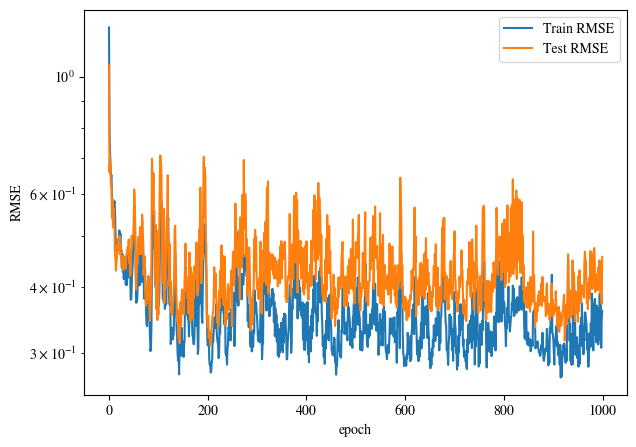

In [35]:
train_mse = np.sqrt(np.array(train_loss_save))
test_mse = np.sqrt(np.array(test_loss_save))
plt.plot(train_mse,label="Train RMSE")
plt.plot(test_mse,label="Test RMSE")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.yscale('log')

In [36]:
model = NeuralNetwork()
checkpoint = torch.load('ANN_reproduction.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_dataloader]):
    for X,y in dataloader:
      X, y = X.to(device), y.to(device)
      y_hat = model(X).numpy().tolist()
      y_storage.extend(y_hat)

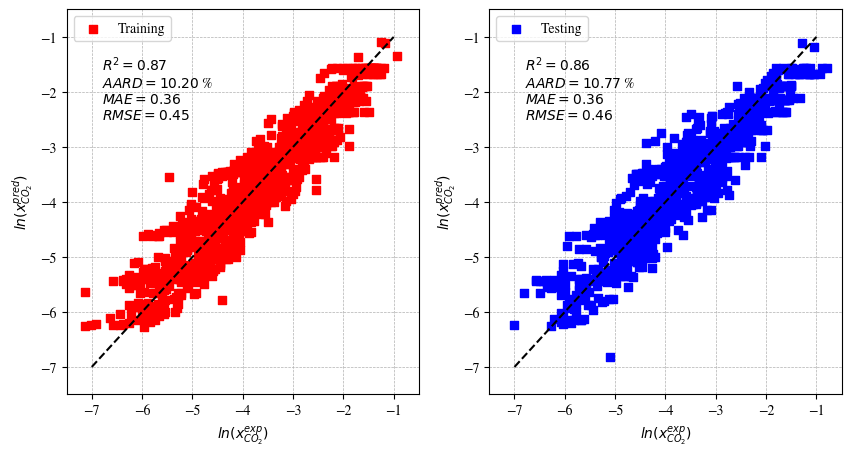

In [37]:
def parity_plots(y_train, y_train_hat, y_test, y_test_hat):

  metrics = [r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error]
  metric_names = ['R2', 'MAPE', 'MAE', 'RMSE']

  metrics_dict = {}
  for split, (y_true, y_pred) in zip(['train', 'test'], [(y_train, y_train_hat), (y_test, y_test_hat)]):
    metrics_dict[split] = {}
    for name, metric in zip(metric_names, metrics):
      metrics_dict[split][name] = metric(y_true, y_pred)

  metrics_train = (r'$R^2 = {:.2f} $' '\n' r'$AARD = {:.2f}$ %' '\n' r'$MAE = {:.2f}$' '\n' r'$RMSE = {:.2f}$' .format(
      metrics_dict['train']['R2'],
      metrics_dict['train']['MAPE']*100,
      metrics_dict['train']['MAE'],
      metrics_dict['train']['RMSE']**0.5))

  metrics_test = (r'$R^2 = {:.2f} $' '\n' r'$AARD = {:.2f}$ %' '\n' r'$MAE = {:.2f}$' '\n' r'$RMSE = {:.2f}$' .format(
      metrics_dict['test']['R2'],
      metrics_dict['test']['MAPE']*100,
      metrics_dict['test']['MAE'],
      metrics_dict['test']['RMSE']**0.5))

  fig , (ax1,ax2) = plt.subplots(1,2, figsize=(10.0 ,5.0))

  ax1.set_xlabel(r'$ln(x^{exp}_{CO_2}) $')
  ax1.set_ylabel(r'$ln(x^{pred}_{CO_2}) $')
  ax1.set_ylim([-7.5,-0.5])
  ax1.set_xlim([-7.5,-0.5])
  ax1.text(-6.8,-2.5, metrics_train, fontsize=10)
  ax1.grid(visible=True,which='major',linestyle = '--' ,linewidth = 0.5)
  ax1.scatter(y_train, y_train_hat, label='Training', marker='s', color='red')
  ax1.plot(np.linspace(-7,-1), np.linspace(-7,-1),linestyle = '--' , color  = 'black')
  ax1.legend(loc="best")

  ax2.set_xlabel(r'$ln(x^{exp}_{CO_2}) $')
  ax2.set_ylabel(r'$ln(x^{pred}_{CO_2}) $')
  ax2.set_ylim([-7.5,-0.5])
  ax2.set_xlim([-7.5,-0.5])
  ax2.text(-6.8,-2.5, metrics_test, fontsize=10)
  ax2.grid(visible=True,which='major', linestyle = '--' ,linewidth = 0.5)
  ax2.scatter(y_test, y_test_hat, label='Testing', marker='s', color='blue')
  ax2.plot(np.linspace(-7,-1),np.linspace(-7,-1),linestyle = '--' , color  = 'black')
  ax2.legend(loc="best")



parity_plots( y_train, y_hat_training, y_test, y_hat_testing)

# New ANN with sigma profiles

I tried with a different learning rate and it goes to nice-ish values

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = NeuralNetwork().to(device)

loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
epochs = 1000

In [39]:
train_loss_save, test_loss_save = [], []
for epoch in tqdm(range(epochs)):
    train_loss = train(model, device, train_dataloader, optimizer, loss_fn)
    train_loss_save.append(train_loss)
    test_loss = test(model,device,test_dataloader,loss_fn)
    test_loss_save.append(test_loss)

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    },
           'new_ANN.pth')

100%|██████████| 1000/1000 [01:02<00:00, 16.03it/s]


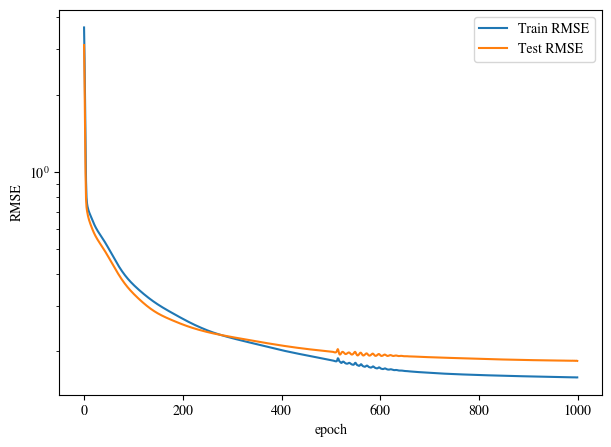

In [40]:
train_mse = np.sqrt(np.array(train_loss_save))
test_mse = np.sqrt(np.array(test_loss_save))
plt.plot(train_mse,label="Train RMSE")
plt.plot(test_mse,label="Test RMSE")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.yscale('log')

In [41]:
model = NeuralNetwork()
checkpoint = torch.load('new_ANN.pth')
model.load_state_dict(checkpoint['model_state_dict'])

y_hat_training, y_hat_testing = [] ,[]
model.eval()
with torch.no_grad():
  for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_dataloader]):
    for X,y in dataloader:
      X, y = X.to(device), y.to(device)
      y_hat = model(X).numpy().tolist()
      y_storage.extend(y_hat)

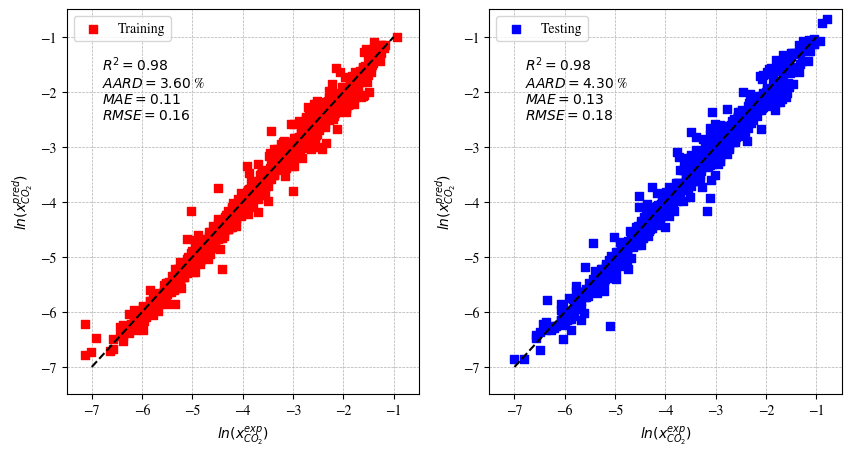

In [42]:
parity_plots( y_train, y_hat_training, y_test, y_hat_testing)

### 10 runs

In [43]:
y_train_hat_lst = []
y_test_hat_lst = []

for i in range(10):
  # Training
  model = NeuralNetwork().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
  train_loss_save, test_loss_save = [], []
  for epoch in tqdm(range(epochs)):
      train_loss = train(model, device, train_dataloader, optimizer, loss_fn)
      train_loss_save.append(train_loss)
      test_loss = test(model,device,test_dataloader,loss_fn)
      test_loss_save.append(test_loss)

  torch.save({
      'epoch': epoch + 1,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      },
            'current_ANN.pth')

  # Prediction
  model = NeuralNetwork()
  checkpoint = torch.load('current_ANN.pth')
  model.load_state_dict(checkpoint['model_state_dict'])

  y_hat_training, y_hat_testing = [] ,[]
  model.eval()
  with torch.no_grad():
    for y_storage, dataloader in zip([y_hat_training, y_hat_testing], [train_dataloader, test_dataloader]):
      for X,y in dataloader:
        X, y = X.to(device), y.to(device)
        y_hat = model(X).numpy().tolist()
        y_storage.extend(y_hat)

  # Store predictions
  y_train_hat_lst.append(y_hat_training)
  y_test_hat_lst.append(y_hat_testing)

100%|██████████| 1000/1000 [01:02<00:00, 15.94it/s]


In [50]:
def MAPE(y_true, y_pred):
  return mean_absolute_percentage_error(y_true, y_pred)*100

metrics = [r2_score, MAPE, mean_absolute_error, mean_squared_error]

def compute_metrics(y_true, y_pred_list, metrics):
    results = {}
    for metric in metrics:
        metric_name = metric.__name__
        scores = [metric(y_true, y_pred) for y_pred in y_pred_list]
        results[metric_name] = {'mean': np.round(np.mean(scores), 2), 'std': np.round(np.std(scores),3)}
    return results

# Compute metrics for training and testing predictions
train_metrics = compute_metrics(y_train, y_train_hat_lst, metrics)
test_metrics = compute_metrics(y_test, y_test_hat_lst, metrics)

In [51]:
train_metrics

{'r2_score': {'mean': 0.99, 'std': 0.002},
 'MAPE': {'mean': 3.37, 'std': 0.231},
 'mean_absolute_error': {'mean': 0.11, 'std': 0.007},
 'mean_squared_error': {'mean': 0.02, 'std': 0.004}}

In [52]:
test_metrics

{'r2_score': {'mean': 0.98, 'std': 0.002},
 'MAPE': {'mean': 3.93, 'std': 0.188},
 'mean_absolute_error': {'mean': 0.12, 'std': 0.005},
 'mean_squared_error': {'mean': 0.03, 'std': 0.003}}